In [1]:
import math
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import style
import matplotlib
import time
import scanpy as sc
import sklearn
import networkx as nx
import ot
import paste as pst
#%load_ext autoreload
#%autoreload 2
# style.use('seaborn-dark')
style.use('seaborn-white')

## Organize data

In [2]:
sample_list = ["151507", "151508", "151509","151510", "151669", "151670","151671", "151672", "151673","151674", "151675", "151676"]
adatas = {sample:sc.read_h5ad('../data/DLPFC/{0}_preprocessed.h5'.format(sample)) for sample in sample_list}
sample_groups = [["151507", "151508", "151509","151510"],[ "151669", "151670","151671", "151672"],[ "151673","151674", "151675", "151676"]]
layer_groups = [[adatas[sample_groups[j][i]] for i in range(len(sample_groups[j]))] for j in range(len(sample_groups))]
layer_to_color_map = {'Layer{0}'.format(i+1):sns.color_palette()[i] for i in range(6)}
layer_to_color_map['WM'] = sns.color_palette()[6]

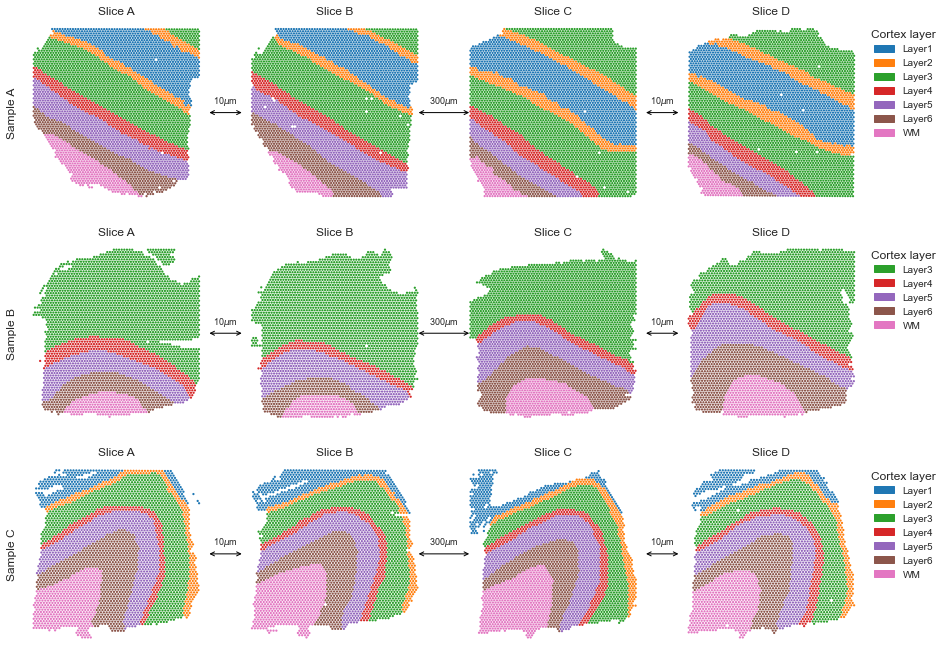

In [5]:
slice_map = {0:'A',1:'B',2:'C',3:'D'}
fig, axs = plt.subplots(3, 4,figsize=(15,11.5))
for j in range(len(layer_groups)):
    axs[j,0].text(-0.1, 0.5, 'Sample '+slice_map[j],fontsize=12,rotation='vertical',transform = axs[j,0].transAxes,verticalalignment='center')
    for i in range(len(layer_groups[j])):
        adata = adatas[sample_list[j*4+i]]
        colors = list(adata.obs['layer_guess_reordered'].astype('str').map(layer_to_color_map))
        axs[j,i].scatter(layer_groups[j][i].obsm['spatial'][:,0],layer_groups[j][i].obsm['spatial'][:,1],linewidth=0,s=20, marker=".",color=colors)
        axs[j,i].set_title('Slice '+ slice_map[i],size=12)
        axs[j,i].invert_yaxis()
        axs[j,i].axis('off')
        if i<3:
            s = '300$\mu$m' if i==1 else "10$\mu$m"
            delta = 0.05 if i==1 else 0
            axs[j,i].annotate('',xy=(1-delta, 0.5), xytext=(1.2+delta, 0.5),xycoords=axs[j,i].transAxes,textcoords=axs[j,i].transAxes,arrowprops=dict(arrowstyle='<->',lw=1))
            axs[j,0].text(1.1, 0.55, s,fontsize=9,transform = axs[j,i].transAxes,horizontalalignment='center')
    axs[j,3].legend(handles=[mpatches.Patch(color=layer_to_color_map[adata.obs['layer_guess_reordered'].cat.categories[i]], label=adata.obs['layer_guess_reordered'].cat.categories[i]) for i in range(len(adata.obs['layer_guess_reordered'].cat.categories))],fontsize=10,title='Cortex layer',title_fontsize=12,bbox_to_anchor=(1, 1))

# Pairwise Alignment

### Run PASTE `pairwise_align`.

In [6]:
def max_accuracy(labels1,labels2):
    w = min(1/len(labels1),1/len(labels2))
    cats = set(pd.unique(labels1)).union(set(pd.unique(labels1)))
    return sum([w * min(sum(labels1==c),sum(labels2==c)) for c in cats])
def mapping_accuracy(labels1,labels2,pi):
    mapping_dict = {'Layer1':1, 'Layer2':2, 'Layer3':3, 'Layer4':4, 'Layer5':5, 'Layer6':6, 'WM':7}
    return np.sum(pi*(scipy.spatial.distance_matrix(np.matrix(labels1.map(mapping_dict) ).T,np.matrix(labels2.map(mapping_dict)).T)==0))
import itertools
def max_accuracy_mapping(labels1,labels2):
    n1,n2=len(labels1),len(labels2)
    mapping_dict = {'Layer1':1, 'Layer2':2, 'Layer3':3, 'Layer4':4, 'Layer5':5, 'Layer6':6, 'WM':7}
    dist = np.array(scipy.spatial.distance_matrix(np.matrix(labels1.map(mapping_dict)).T,np.matrix(labels2.map(mapping_dict)).T)!=0,dtype=float)
    pi = ot.emd(np.ones(n1)/n1, np.ones(n2)/n2, dist)
    return pi

In [7]:
alpha = 0.1
res_df = pd.DataFrame(columns=['Sample','Pair','Kind','Time','Accuracy'])
pis = [[None for i in range(len(layer_groups[j])-1)] for j in range(len(layer_groups))]
for j in range(len(layer_groups)):
    for i in range(len(layer_groups[j])-1):
#         pi0=np.loadtxt('paste_output/DLPFC/init_{0}_{1}_{2}.gz'.format(j,i,'ot'), delimiter=',')
        pi0 = pst.match_spots_using_spatial_heuristic(layer_groups[j][i].obsm['spatial'],layer_groups[j][i+1].obsm['spatial'],use_ot=True)
        start = time.time()
        pis[j][i] = pst.pairwise_align(layer_groups[j][i], layer_groups[j][i+1],alpha=alpha,G_init=pi0,norm=True,verbose=False)
        tt = time.time()-start
        acc = mapping_accuracy(layer_groups[j][i].obs['layer_guess_reordered'],layer_groups[j][i+1].obs['layer_guess_reordered'],pis[j][i])
        print(j,i,'Accuracy',acc,'time',tt)
        np.savetxt('../data/DLPFC/saved_results/init_{0}_{1}_{2}.gz'.format(j,i,'ot'), pis[j][i], delimiter=',')
        res_df.loc[len(res_df)] = [j,i,'PASTE',tt,acc]

Filtered all slices for common genes. There are 9219 common genes.
0 0 Accuracy 0.8159939348614484 time 513.2139248847961
Filtered all slices for common genes. There are 9248 common genes.


/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ot/lp/__init__.py:276: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



0 1 Accuracy 0.22021005545690667 time 105.91374802589417
Filtered all slices for common genes. There are 10032 common genes.


/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ot/lp/__init__.py:276: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



0 2 Accuracy 0.868547124118905 time 49.55179286003113
Filtered all slices for common genes. There are 9915 common genes.
1 0 Accuracy 0.915010735974029 time 557.0477240085602
Filtered all slices for common genes. There are 9965 common genes.


/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ot/lp/__init__.py:276: UserWarning:

numItermax reached before optimality. Try to increase numItermax.



1 1 Accuracy 0.591953543941538 time 26.885112762451172
Filtered all slices for common genes. There are 10543 common genes.
1 2 Accuracy 0.8617461955275575 time 321.1038429737091
Filtered all slices for common genes. There are 11373 common genes.
2 0 Accuracy 0.8587272498025936 time 306.32546401023865
Filtered all slices for common genes. There are 10629 common genes.
2 1 Accuracy 0.8281695302031095 time 274.6831839084625
Filtered all slices for common genes. There are 10493 common genes.
2 2 Accuracy 0.8284832642498049 time 246.19244694709778


## Rotate and plot new coordinates

In [8]:
new_layer_groups = [pst.stack_slices_pairwise(layer_groups[j], pis[j]) for j in range(len(layer_groups)) ]

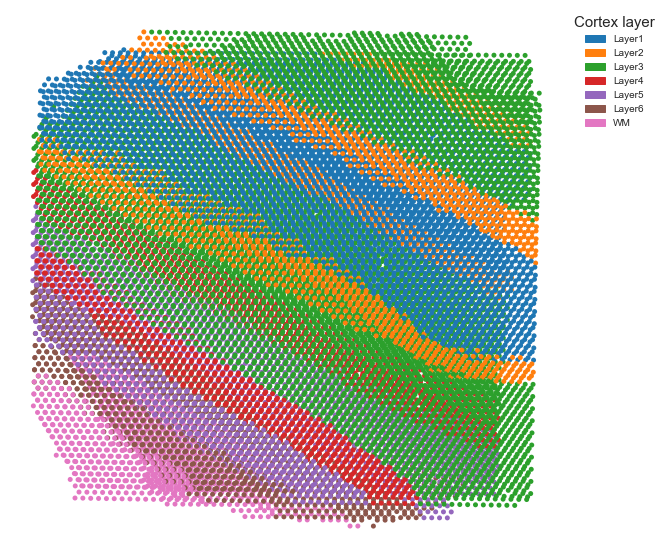

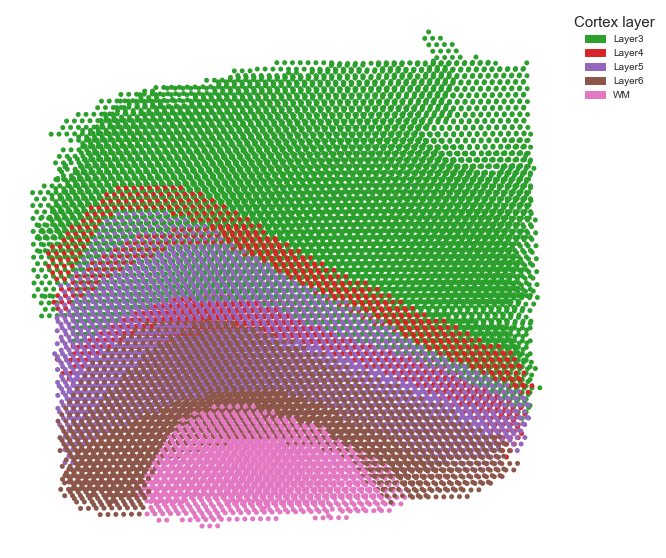

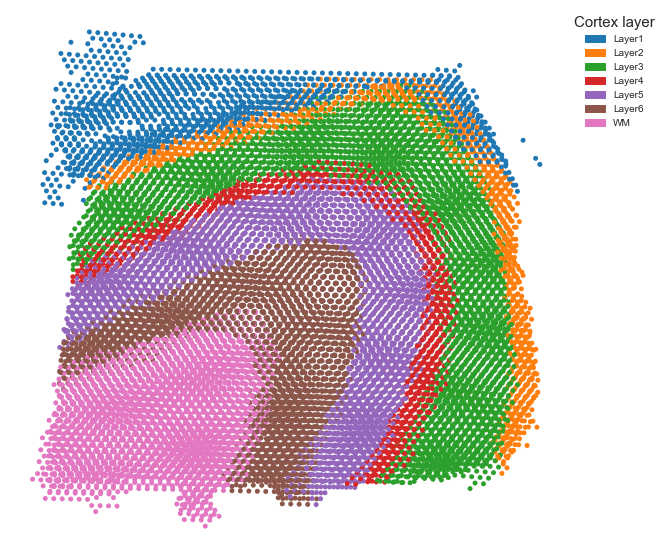

In [9]:
layer_to_color_map = {'Layer{0}'.format(i+1):sns.color_palette()[i] for i in range(6)}
layer_to_color_map['WM'] = sns.color_palette()[6]
for j in range(len(new_layer_groups)): 
    plt.figure(figsize=(10,10))
    for i in range(len(new_layer_groups[j])):
        adata = adatas[sample_list[j*4+i]]
        colors = list(adata.obs['layer_guess_reordered'].astype('str').map(layer_to_color_map))
        plt.scatter(new_layer_groups[j][i].obsm['spatial'][:,0],new_layer_groups[j][i].obsm['spatial'][:,1],linewidth=0,s=100, marker=".",color=colors)
    plt.legend(handles=[mpatches.Patch(color=layer_to_color_map[adata.obs['layer_guess_reordered'].cat.categories[i]], label=adata.obs['layer_guess_reordered'].cat.categories[i]) for i in range(len(adata.obs['layer_guess_reordered'].cat.categories))],fontsize=10,title='Cortex layer',title_fontsize=15,bbox_to_anchor=(1, 1))
    plt.gca().invert_yaxis()
    plt.axis('off') 
    plt.show()

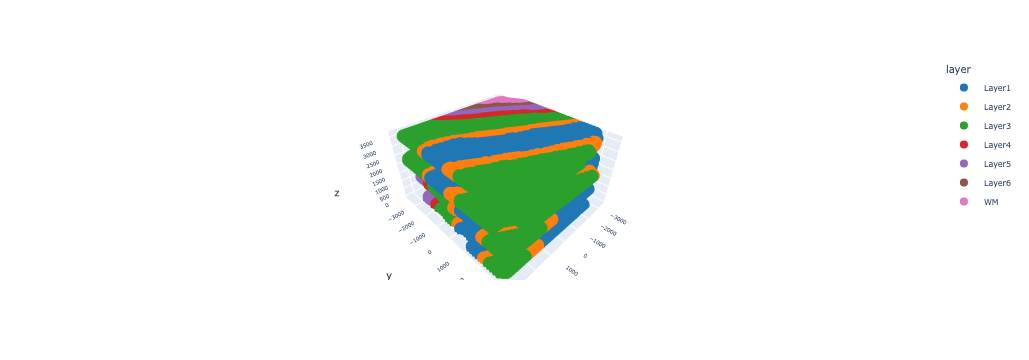

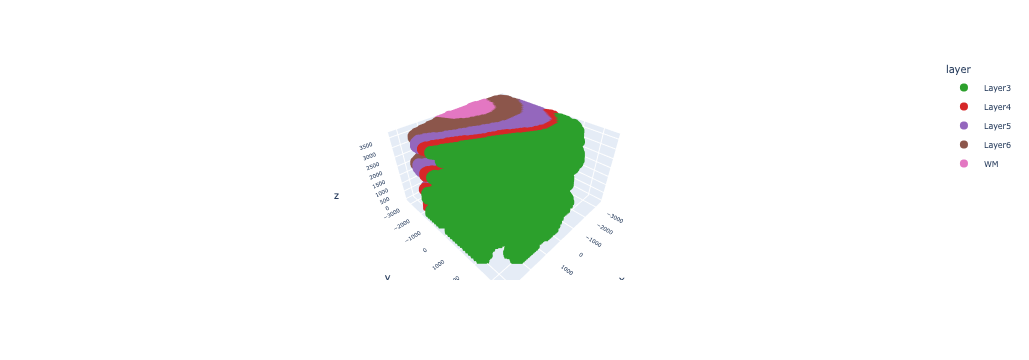

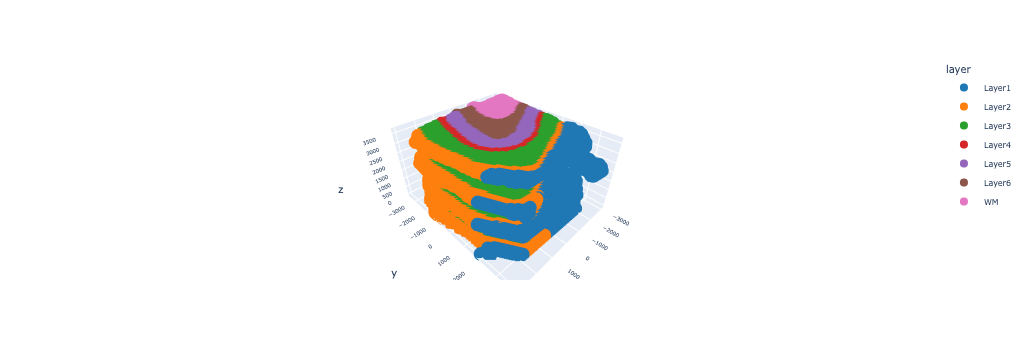

In [12]:
import plotly.express as px
import plotly.io as pio
# if using plain jupyter notebook use:
pio.renderers.default='notebook'
# If using jupyterlab use:
#pio.renderers.default='jupyterlab'
config = {
      'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': "DLPFC_3d"
      }
    }

factor = 6.1656/100
z_difference = [np.array([0,10,300,10])*factor for j in range(len(new_layer_groups))]
z_coordinates = [[z_difference[j][:i+1].sum() for i in range(len(z_difference[j]))] for j in range(len(z_difference))]
z_coordinates = np.array([[0,1,2,3] for j in range(3)])*75

for j in range(len(new_layer_groups)): 
    df = pd.DataFrame(columns=['x','y','z','layer'])
    for i,L in enumerate(new_layer_groups[j]):
        adata = adatas[sample_list[j*4+i]]
        df_ = pd.DataFrame(np.concatenate((L.obsm['spatial'],np.matrix(z_coordinates[j][i]*np.ones(len(adata))).T,np.matrix(np.ones(len(adata),dtype=int)).T),axis=1),columns=['x','y','z','layer'])
        df_.loc[:,"layer"] = list(adata.obs['layer_guess_reordered'])
        df = df.append(df_, ignore_index=True)
    df = df.sort_values(by=['layer'])
    df['y'] = -df['y']
    df[['x','y','z']] = df[['x','y','z']]/factor
    fig = px.scatter_3d(df, x='x', y='y', z='z',
                  color='layer',color_discrete_sequence=[matplotlib.colors.to_hex(layer_to_color_map[c]) for c in sorted(list(adata.obs['layer_guess_reordered'].cat.categories))])#adata.uns['layer_guess_reordered_colors'])
    fig.update_layout(scene_aspectmode='data',font=dict(size=8))
    fig.show(config=config)

## Benchmarks

In [14]:
import tangram as tg
def align_tg(slice1,slice2,num_epochs=1000,density_prior=None,random_state=None):
    ad_sp = slice2.copy()
    ad_sc = slice1.copy()
    tg.pp_adatas(ad_sc, ad_sp, genes=None)
    ad_map = tg.map_cells_to_space(ad_sc, ad_sp, num_epochs=num_epochs,density_prior=density_prior,random_state=random_state)
    return ad_map
tangram_pis = [[None for i in range(len(layer_groups[j])-1)] for j in range(len(layer_groups))]
for j in range(len(layer_groups)):
    for i in range(len(layer_groups[j])-1):
        start = time.time()
        tangram_pis[j][i] = align_tg(layer_groups[j][i],layer_groups[j][i+1],num_epochs=300,density_prior='uniform',random_state=0)
        tt = time.time()-start
        tangram_pis[j][i] = tangram_pis[j][i].X/tangram_pis[j][i].X.sum()
        acc = mapping_accuracy(layer_groups[j][i].obs['layer_guess_reordered'],layer_groups[j][i+1].obs['layer_guess_reordered'],tangram_pis[j][i])
        res_df.loc[len(res_df)] = [j,i,'Tangram',tt,acc]

INFO:root:9219 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:9219 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 9219 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.292, KL reg: 0.000
Score: 0.382, KL reg: 0.001
Score: 0.388, KL reg: 0.001


INFO:root:Saving results..
INFO:root:9248 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:9248 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 9248 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.321, KL reg: 0.000
Score: 0.416, KL reg: 0.001
Score: 0.424, KL reg: 0.001


INFO:root:Saving results..
INFO:root:10032 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:10032 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 10032 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.301, KL reg: 0.000
Score: 0.390, KL reg: 0.001
Score: 0.397, KL reg: 0.001


INFO:root:Saving results..
INFO:root:9915 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:9915 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 9915 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.336, KL reg: 0.000
Score: 0.426, KL reg: 0.001
Score: 0.431, KL reg: 0.001


INFO:root:Saving results..
INFO:root:9965 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:9965 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 9965 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.354, KL reg: 0.000
Score: 0.442, KL reg: 0.001
Score: 0.447, KL reg: 0.001


INFO:root:Saving results..
INFO:root:10543 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:10543 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 10543 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.335, KL reg: 0.000
Score: 0.419, KL reg: 0.001
Score: 0.425, KL reg: 0.001


INFO:root:Saving results..
INFO:root:11373 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:11373 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 11373 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.400, KL reg: 0.000
Score: 0.488, KL reg: 0.001
Score: 0.493, KL reg: 0.001


INFO:root:Saving results..
INFO:root:10629 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:10629 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 10629 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.338, KL reg: 0.000
Score: 0.426, KL reg: 0.001
Score: 0.430, KL reg: 0.001


INFO:root:Saving results..
INFO:root:10493 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:10493 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 10493 genes and uniform density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.352, KL reg: 0.000
Score: 0.445, KL reg: 0.001
Score: 0.450, KL reg: 0.001


INFO:root:Saving results..


In [16]:
import pickle
outfile = open('../data/DLPFC/saved_results/tangram_pis.pickle','wb')
pickle.dump(tangram_pis,outfile)
outfile.close()

In [17]:
seurat_anchors = {}
seurat_pis = [[0,0,0],[0,0,0],[0,0,0]]
for j in range(3):
    seurat_anchors[j] = pd.read_csv('../data/DLPFC/saved_results/sample{0}-anchors.csv'.format(j+1))
    for i in range(3):
        temp = seurat_anchors[j][(seurat_anchors[j]['dataset1']==i+1)&((seurat_anchors[j]['dataset2']==i+2))]
        seurat_pi = np.zeros((len(layer_groups[j][i]),len(layer_groups[j][i+1])))
        for k in range(len(temp)):
            seurat_pi[int(temp.iloc[k]['cell1'])-1,int(temp.iloc[k]['cell2'])-1] = float(temp.iloc[k]['score'])
        seurat_pis[j][i] = seurat_pi/seurat_pi.sum()
        acc = mapping_accuracy(layer_groups[j][i].obs['layer_guess_reordered'],layer_groups[j][i+1].obs['layer_guess_reordered'],seurat_pis[j][i])
        res_df.loc[len(res_df)] = [j,i,'Seurat',-1,acc]

In [35]:
stutility_slices = [[None for i in range(len(layer_groups[j]))] for j in range(len(layer_groups))]
for j in range(len(layer_groups)): 
    for i in range(len(layer_groups[j])):
        stutility_slices[j][i] = layer_groups[j][i].copy()
        stu_coord = pd.read_csv('../data/DLPFC/saved_results/{0}-STUtil-coords-default.csv'.format(sample_list[j*4+i]),sep=',',index_col=0)
        temp = stutility_slices[j][i].obs.index.copy()
        temp = temp.map(lambda x: x.split('.')[0])
        mat_df = stu_coord[stu_coord['barcode']==temp].reset_index()[['align_x','align_y']]
        stutility_slices[j][i].obsm['spatial'] = mat_df.to_numpy()
        
stu_pis = [[None for i in range(len(layer_groups[j])-1)] for j in range(len(layer_groups))]
for j in range(len(layer_groups)): 
    for i in range(len(layer_groups[j])-1):
        pi0 = np.loadtxt('../data/DLPFC/saved_results/{0}-{1}-stutil-alignment.csv'.format(sample_list[j*4+i],sample_list[j*4+i+1]), delimiter=',')
        stu_pis[j][i] = pi0
        acc = mapping_accuracy(stutility_slices[j][i].obs['layer_guess_reordered'],stutility_slices[j][i+1].obs['layer_guess_reordered'],stu_pis[j][i])
        print(acc,end=', ') 
        res_df.loc[len(res_df)] = [j,i,'STUtility',-1,acc]

0.8054895239991768, 0.21121387482921625, 0.21409480569142927, 0.9106635057052567, 0.10888622829108002, 0.15489120596647452, 0.8560103489376286, 0.8354734189089879, 0.8354007447192715, 

In [66]:
sample_index = []
pair_index = []
for j in range(len(layer_groups)):
    for i in range(len(layer_groups[j])-1):
        sample_index.append(j)
        pair_index.append(i)
        
res_df['Sample'] = sample_index * 5
res_df['Pair'] = pair_index * 5
sample_map,pair_map = {0:'I',1:'II',2:'III'},{0:'AB',1:'BC',2:'CD'}
res_df['Sample'] = res_df['Sample'].map(sample_map)
res_df['Pair'] = res_df['Pair'].map(pair_map)

<Figure size 1440x360 with 0 Axes>

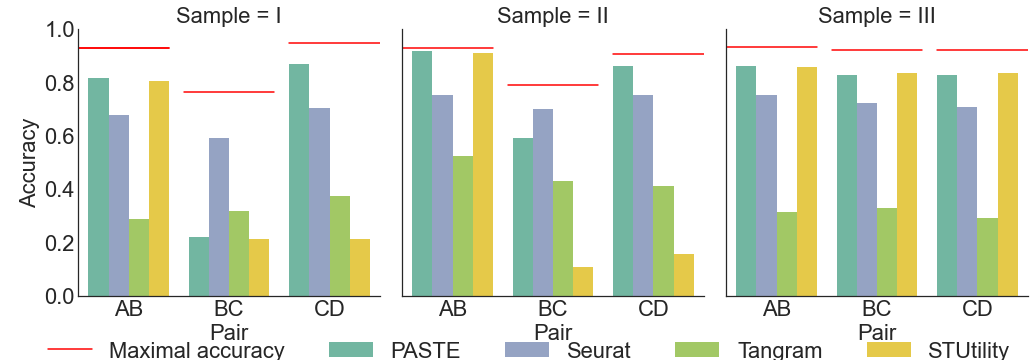

In [79]:
res_df = res_df.sort_index()
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,5))

g = sns.catplot(x="Pair", y="Accuracy", hue='Kind', col="Sample",data=res_df,kind="bar", ci=None, aspect=1,legend=False,
                palette=sns.color_palette("Set2")[:1]+sns.color_palette("Set2")[2:3]+sns.color_palette("Set2")[4:6],hue_order=['PASTE','Seurat','Tangram','STUtility'])
g.set_axis_labels("Pair", "Accuracy").set(ylim=(0, 1))

max_acc = max_accuracy(adatas[sample_list[0*4+0]].obs['layer_guess_reordered'],adatas[sample_list[0*4+0+1]].obs['layer_guess_reordered'])
g.axes[0][0].axhline(max_acc, 0.35*0, 0.35*0+0.3,color='r')
g.add_legend(title='',labels=['Maximal accuracy','PASTE','Seurat','Tangram','STUtility'],bbox_to_anchor=(0.5, 0.025),ncol=5)#(1.0, 0.5))(0.52,-0.1)
for j in range(3):
    for i in range(3):
        max_acc = max_accuracy(adatas[sample_list[j*4+i]].obs['layer_guess_reordered'],adatas[sample_list[j*4+i+1]].obs['layer_guess_reordered'])
        g.axes[0][j].axhline(max_acc, 0.35*i, 0.35*i+0.3,color='r')
plt.show()